In [1]:
######################################################################
# Set Up the Environment
######################################################################
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import pandas as pd

# Create a directory to save model and plots
os.makedirs("output", exist_ok=True)

In [3]:

######################################################################
# Load and Preprocess the MNIST Dataset
######################################################################
# Define transformations
train_transform = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Download dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True)


In [6]:
train_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test)

In [7]:

# Apply transformations
train_dataset.transform = train_transform
test_dataset.transform = test_transform

In [9]:

# Split training data for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


In [11]:

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



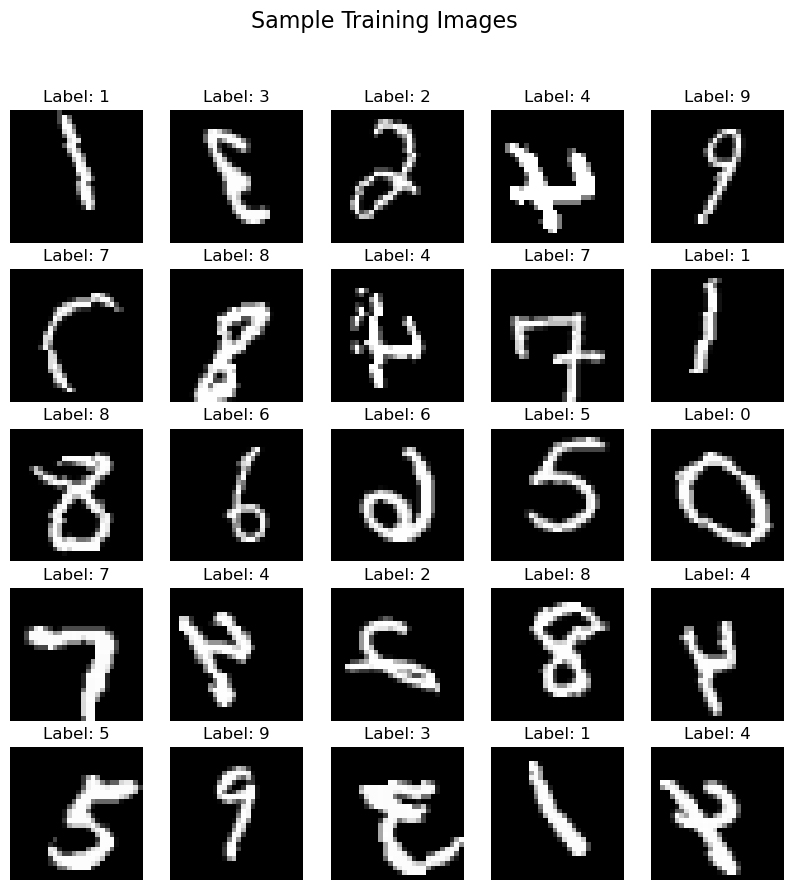

In [12]:

######################################################################
# Visualize Sample Data
######################################################################
def visualize_samples(dataset):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        img, label = dataset[i]
        img = img.squeeze().numpy()
        plt.subplot(5, 5, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.suptitle("Sample Training Images", fontsize=16)
    plt.savefig("output/sample_training_images.png")
    plt.show()


visualize_samples(train_dataset)

In [13]:

######################################################################
# Define an Advanced Neural Network Model (CNN-based)
######################################################################
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:

######################################################################
# Train the Model
######################################################################
def train_model(model, train_loader, val_loader, epochs=10):
    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    patience, counter = 2, 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), "output/mnist_model.pth")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break

    return train_losses, val_losses


train_losses, val_losses = train_model(model, train_loader, val_loader)

Epoch 1: Train Loss: 0.5939, Val Loss: 0.2856
Epoch 2: Train Loss: 0.2624, Val Loss: 0.1829
Epoch 3: Train Loss: 0.1873, Val Loss: 0.1471
Epoch 4: Train Loss: 0.1536, Val Loss: 0.1259
Epoch 5: Train Loss: 0.1375, Val Loss: 0.1127
Epoch 6: Train Loss: 0.1228, Val Loss: 0.1067
Epoch 7: Train Loss: 0.1173, Val Loss: 0.0970
Epoch 8: Train Loss: 0.1052, Val Loss: 0.0970
Epoch 9: Train Loss: 0.1035, Val Loss: 0.0919
Epoch 10: Train Loss: 0.0980, Val Loss: 0.0819


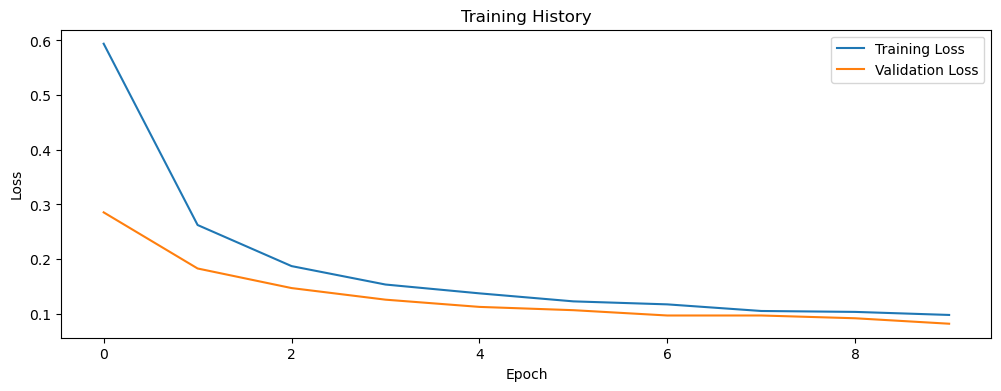

In [15]:
######################################################################
# Plot Training History
######################################################################
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("output/training_history.png")
plt.show()


In [17]:

######################################################################
# Evaluate the Model
######################################################################
def evaluate_model(model, test_loader):
    model.load_state_dict(torch.load("output/mnist_model.pth", weights_only=True))
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return all_labels, all_preds


labels, preds = evaluate_model(model, test_loader)

Test Accuracy: 98.56%


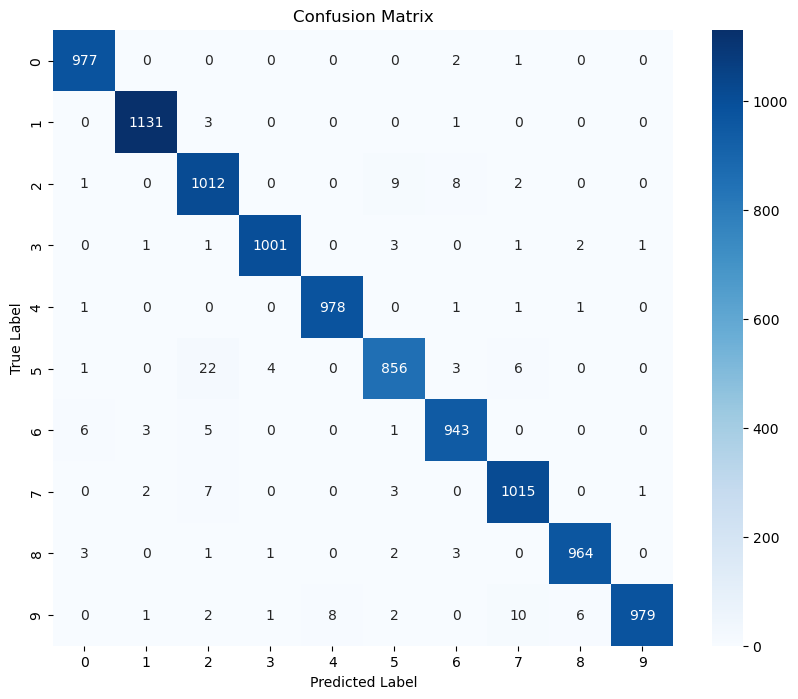

In [18]:

######################################################################
# Confusion Matrix
######################################################################
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(10),
    yticklabels=range(10),
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("output/confusion_matrix.png")
plt.show()

In [19]:

######################################################################
# Classification Report
######################################################################
print("Classification Report:")
print(classification_report(labels, preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.96      0.98      0.97      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [20]:

######################################################################
# Save Predictions to CSV
######################################################################
results = pd.DataFrame({"True Label": labels, "Predicted Label": preds})
results.to_csv("output/predictions.csv", index=False)
print("Predictions exported to output/predictions.csv")



Predictions exported to output/predictions.csv


F1-scores per class: [0.99238192 0.99516058 0.97074341 0.99256321 0.99390244 0.96832579
 0.98280354 0.98352713 0.9902414  0.9839196 ]


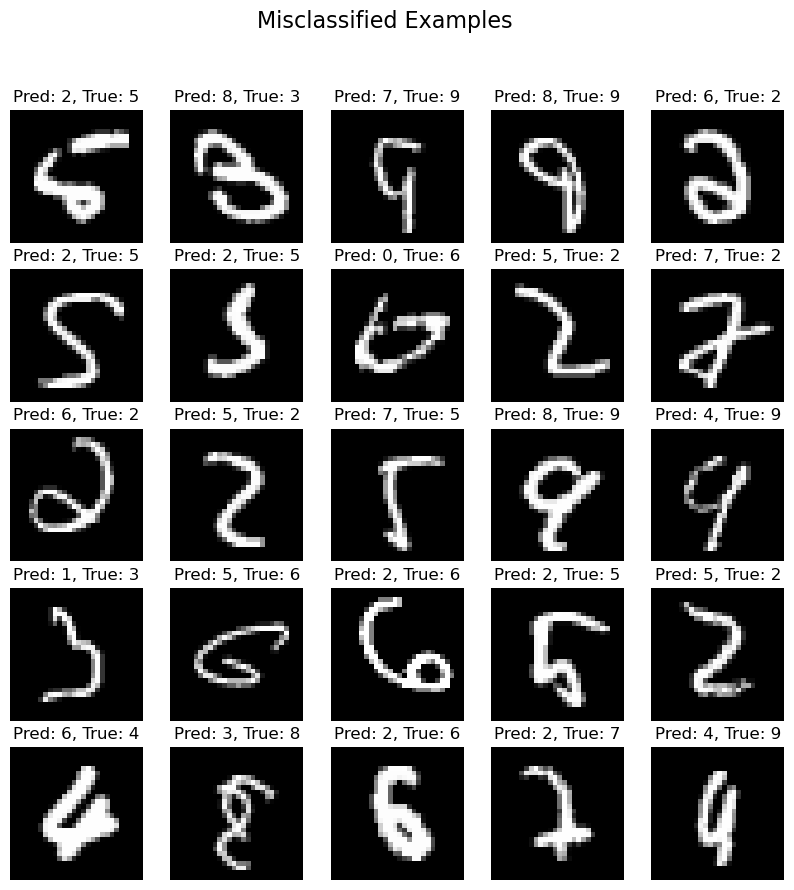

In [22]:

######################################################################
# Robust Error Analysis: Misclassified Images and F1-score per Class
######################################################################
def analyze_errors(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            misclassified.extend(
                [
                    (img, pred, lbl)
                    for img, pred, lbl in zip(
                        images.cpu(), predicted.cpu(), labels.cpu()
                    )
                    if pred != lbl
                ]
            )

    # Compute F1-score per class
    f1_scores = f1_score(all_labels, all_preds, average=None)
    print("F1-scores per class:", f1_scores)

    # Visualize misclassified images
    plt.figure(figsize=(10, 10))
    for i, (img, pred, lbl) in enumerate(misclassified[:25]):
        plt.subplot(5, 5, i + 1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(f"Pred: {pred}, True: {lbl}")
        plt.axis("off")
    plt.suptitle("Misclassified Examples", fontsize=16)
    plt.savefig("output/misclassified_examples.png")
    plt.show()

    return all_labels, all_preds


labels, preds = analyze_errors(model, test_loader)


In [23]:

######################################################################
# Save Predictions to CSV
######################################################################
results = pd.DataFrame({"True Label": labels, "Predicted Label": preds})
results.to_csv("output/predictions.csv", index=False)
print("Predictions exported to output/predictions.csv")

Predictions exported to output/predictions.csv
